# **Environment Setup**

In [1]:
# --- Imports ---
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import brevitas.nn as qnn
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerChannelFloat, Uint8ActPerTensorFloat

from brevitas.export import export_qonnx

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score



In [2]:
# --- Globals ---

# Valid labels for raw input (before AAMI conversion)

AAMI_CLASSES = {
    'N': ['N', '·', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F']
}

# Generate AAMI_MAP from AAMI_CLASSES
AAMI_MAP = {}
for aami_label, raw_list in AAMI_CLASSES.items():
    for raw_label in raw_list:
        AAMI_MAP[raw_label] = aami_label

#AAMI_HIERARCHY_ORDER_FOR_LABELS = ['V', 'F', 'S', 'Q', 'N'] # This is the order that determined the integer labels
#AAMI_CLASS_NAMES = AAMI_HIERARCHY_ORDER_FOR_LABELS

AAMI_CLASS_NAMES = list(AAMI_CLASSES.keys())  # ['N', 'S', 'V', 'F']



save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed/'



class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels):#, win_ids):
        self.inputs = inputs
        self.labels = labels
        #self.win_ids = win_ids

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]#, self.win_ids[idx]

## **Load Train, Val, Test**

In [3]:
# # --- Split train/val/test from .pt-files ---


train_data = torch.load(os.path.join(save_dir, "train.pt"))
train_inputs = train_data["inputs"]
train_labels = train_data["labels"]
#train_ids = train_data["window_ids"]

val_data = torch.load(os.path.join(save_dir, "val.pt"))
val_inputs = val_data["inputs"]
val_labels = val_data["labels"]
#val_ids = val_data["window_ids"]

test_data = torch.load(os.path.join(save_dir, "test.pt"))
test_inputs = test_data["inputs"]
test_labels = test_data["labels"]
#test_ids = test_data["window_ids"]



train_dataset = PreprocessedECGDataset(train_inputs, train_labels)#, train_ids)
val_dataset   = PreprocessedECGDataset(val_inputs, val_labels)#, val_ids)
test_dataset  = PreprocessedECGDataset(test_inputs, test_labels)#, test_ids)



batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


test_inputs_numpy = test_inputs.numpy()
test_labels_numpy = test_labels.numpy()

# Save the data to .npy files
np.save('/home/eveneiha/finn/workspace/ml/data/input.npy', test_inputs_numpy)
np.save('/home/eveneiha/finn/workspace/ml/data/labels.npy', test_labels_numpy)

print("Test data saved to .npy files.")

/tmp/ipykernel_1723180/1200186718.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))
/tmp/ipykernel_1723180/1200

Test data saved to .npy files.


/tmp/ipykernel_1723180/1200186718.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(save_dir, "test.pt"))


/tmp/ipykernel_1723180/1728301886.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))



Plotting random window (Raw Label):
Filtering for labels [0]... (can be slow on large datasets)
Found 61942 samples matching filter.


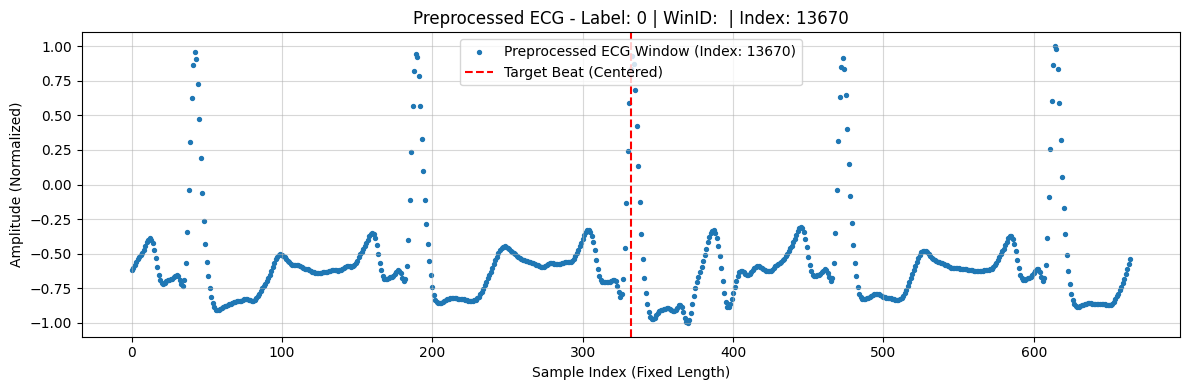


Plotting random window (AAMI Label):
Filtering for labels [1]... (can be slow on large datasets)
Found 1933 samples matching filter.


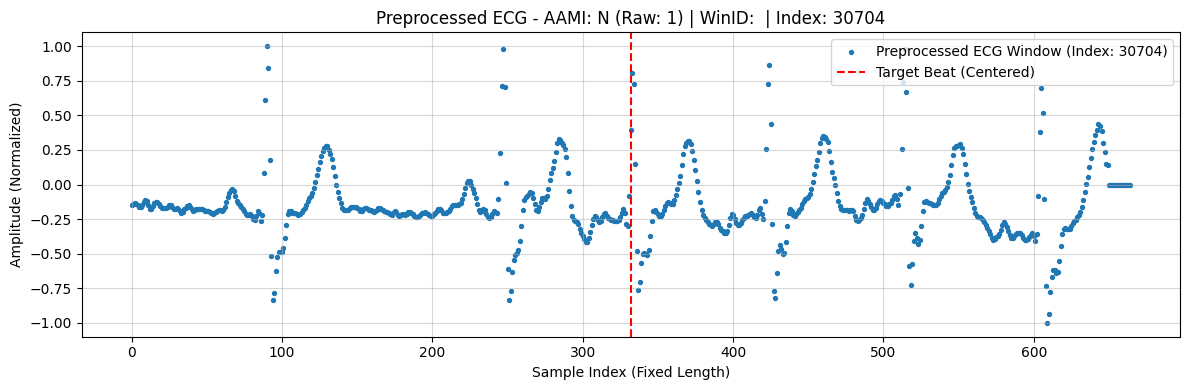


Plotting random window with Label 2 (AAMI Label):
Filtering for labels [2]... (can be slow on large datasets)
Found 4857 samples matching filter.


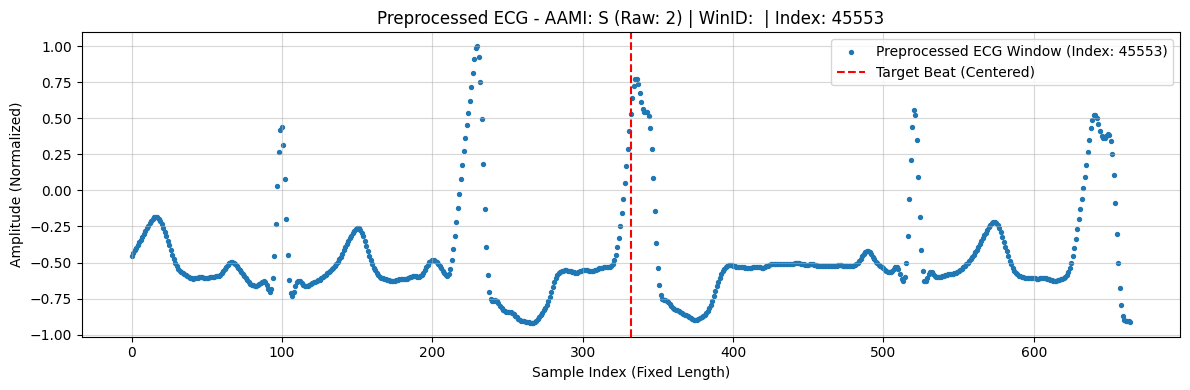


Plotting random window with Label 1 or 2 (Raw Label):
Filtering for labels [3]... (can be slow on large datasets)
Found 560 samples matching filter.


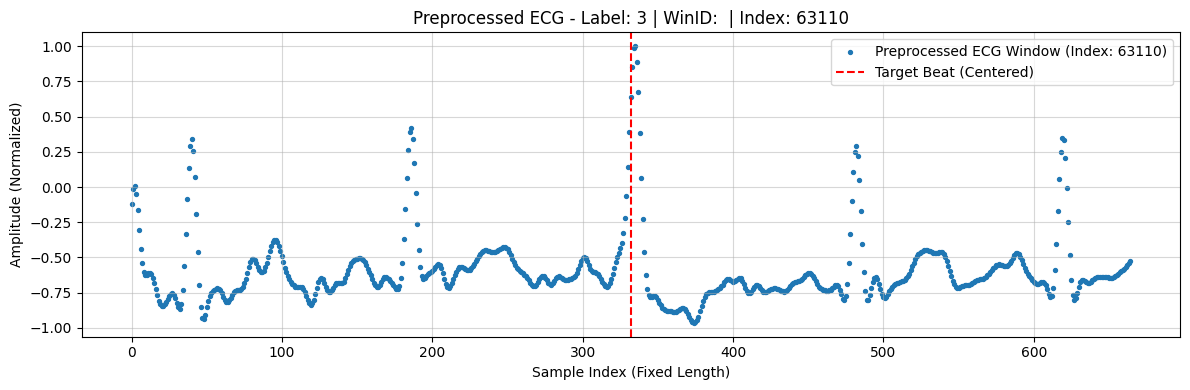

Filtering for labels [4]... (can be slow on large datasets)
No samples found with label(s): [4]


In [4]:
# --- Plotting of inputs for visualization ---

AAMI_MAP = {
    1: 'N',    # Normal beat
    2: 'S',    # Supraventricular ectopic beat (SVEB)
    3: 'V',    # Ventricular ectopic beat (VEB)
    4: 'F',    # Fusion beat
   # 5: 'Q',    # Unknown beat / Unclassifiable
}


def plot_random_preprocessed_window(data_source, label_filter=None, title_label='raw', figsize=(12, 4)):

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"
    if title_label == 'aami' and 'AAMI_MAP' not in globals():
        print("⚠️ Warning: title_label='aami' requires AAMI_MAP to be defined globally.")
        print("Falling back to title_label='raw'.")
        title_label = 'raw'

    possible_indices = list(range(len(data_source)))

    # --- Filter indices based on label_filter if provided ---
    if label_filter is not None:
        if isinstance(label_filter, int):
            label_filter = [label_filter] # Ensure it's a list

        filtered_indices = []
        print(f"Filtering for labels {label_filter}... (can be slow on large datasets)")
        # Iterate through indices and check labels efficiently
        all_labels = data_source.labels # Access the full labels tensor directly
        for i in possible_indices:
             # Check if the label at index i is in the filter list
             if all_labels[i].item() in label_filter:
                 filtered_indices.append(i)

        if not filtered_indices:
            print(f"No samples found with label(s): {label_filter}")
            return
        possible_indices = filtered_indices
        print(f"Found {len(possible_indices)} samples matching filter.")

    # --- Select a random sample ---
    if not possible_indices:
        print("No samples available in the dataset.")
        return
    random_idx = random.choice(possible_indices)
    ecg_tensor, label_tensor = data_source[random_idx]

    # --- Data Extraction and Preparation ---
    # Ensure tensor is on CPU and convert to numpy
    ecg_np = ecg_tensor.squeeze().cpu().numpy()
    label = label_tensor.item() # Get scalar label value

    # Handle potential multi-channel data (plot the first channel)
    if ecg_np.ndim > 1:
        print(f"Input tensor has {ecg_np.shape} shape. Plotting channel 0.")
        ecg_np = ecg_np[0, :] # Select first channel

    fixed_len = ecg_np.shape[0]
    # The preprocessing is assumed to place the target beat at the center
    center_pos = fixed_len // 2

    # --- Plotting ---
    # Choose title based on label mapping
    if title_label == 'aami':
        aami_label_str = AAMI_MAP.get(label, f'Unknown ({label})') # Use get for safety
        title = f"Preprocessed ECG - AAMI: {aami_label_str} (Raw: {label}) | WinID:  | Index: {random_idx}"
    else: # 'raw'
        title = f"Preprocessed ECG - Label: {label} | WinID:  | Index: {random_idx}"

    plt.figure(figsize=figsize)
    #plt.plot(ecg_np, label=f"Preprocessed ECG Window (Index: {random_idx})")
    plt.scatter(range(len(ecg_np)), ecg_np, s=8, label=f"Preprocessed ECG Window (Index: {random_idx})")

    # Mark the assumed center (target beat position)
    # Note: We cannot mark other beats as their processed positions are unknown
    plt.axvline(x=center_pos, color='r', linestyle='--', linewidth=1.5, label="Target Beat (Centered)")

    plt.title(title)
    plt.xlabel("Sample Index (Fixed Length)")
    plt.ylabel("Amplitude (Normalized)") # Assuming data is normalized
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


try:
    train_data = torch.load(os.path.join(save_dir, "train.pt"))
    train_inputs = train_data["inputs"]
    train_labels = train_data["labels"]
    #train_ids = train_data["window_ids"]

    # 2. Create Dataset instances
    train_dataset = PreprocessedECGDataset(train_inputs, train_labels)

    # 3. Call the plotting function
    print("\nPlotting random window (Raw Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=0, title_label='raw')

    print("\nPlotting random window (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=1, title_label='aami')

    # Example with label filter (e.g., plot only class 2 - 'V' if using AAMI_MAP above)
    print("\nPlotting random window with Label 2 (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=2, title_label='aami')

    # Example with multiple label filter
    print("\nPlotting random window with Label 1 or 2 (Raw Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=3, title_label='raw')
    plot_random_preprocessed_window(train_dataset, label_filter=4, title_label='raw')

except FileNotFoundError:
    print(f"Error: Data files not found in {save_dir}. Please check the path.")
except KeyError as e:
    print(f"Error: Missing key {e} in loaded .pt file. Ensure files contain 'inputs', 'labels', 'window_ids'.")


# **TCN ORIGINAL**

In [5]:
# --- Main TCN Architecture ---
class TemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, not_first = False):
        super(TemporalBlock2d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
        self.conv_quant = Int8ActPerTensorFloat
        if not_first:
            self.conv_quant = None
                
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant= self.conv_quant,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )
        
        
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)
   
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(1, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )       
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = qnn.QuantReLU(
            act_quant=Uint8ActPerTensorFloat,   
            output_quant=Int8ActPerTensorFloat, 
            act_bit_width=8,
            output_bit_width=8,
            return_quant_tensor=False
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x


class TCN2d(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        # We also need a 1x1 conv to get to num_outputs
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=None,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False,
        )


    def forward(self, x): # Input is float
        for block in self.temporal_blocks:
            x = block(x) 
        x = self.fc(x) # Output likely INT32 internal or QuantTensor
        x = x.value if hasattr(x, 'value') else x      
        
        ## consider adding a softmax layer here 
        x = x.value if hasattr(x, 'value') else x
        x_reshaped = x.reshape(x.size(0), -1)
        return x_reshaped
    
block1 = TemporalBlock2d(1, 4, kernel_size=9, dilation=1,  stride=2,  dropout=0.036)
block2 = TemporalBlock2d(4, 8, kernel_size=9, dilation=4,  stride=1,  dropout=0.036, not_first=True) # 0.036
block3 = TemporalBlock2d(8, 16, kernel_size=9, dilation=16,  stride=1,  dropout=0, not_first=True) # 0.05

custom_blocks = [block1, block2, block3]

## **SETUP TRAINING** 

In [6]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN2d(custom_blocks=custom_blocks, num_outputs=4).to(device)
# Optimizer
lr = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-3,  # require >0.001 improvement
    threshold_mode='rel',  # relative improvement (can also use 'abs')
    verbose=True)


class NonUniformLabelSmoothingLoss(nn.Module):
    def __init__(self, class_counts, smoothing=0.03, reduction='mean'):
        super().__init__()
        self.smoothing = smoothing
        self.reduction = reduction

        # Compute class weights: inverse freq ^ 1.5 (as you did)
        class_weights = 1.0 / (class_counts.float()** 1.5)
        class_weights = class_weights / class_weights.sum()
        self.register_buffer("class_weights", class_weights)

    def forward(self, logits, target):
        """
        logits: (batch_size, num_classes)
        target: (batch_size,)  -- integer class labels
        """
        with torch.no_grad():
            # Create smoothed target distribution
            true_dist = self.class_weights.unsqueeze(0).repeat(target.size(0), 1)  # (batch, num_classes)
            true_dist = true_dist * self.smoothing  # distribute smoothing mass
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)  # set true class to 1 - ε

        log_probs = F.log_softmax(logits, dim=1)
        loss = -(true_dist * log_probs).sum(dim=1)


        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # no reduction




class_counts = torch.tensor([
    61998,  # Class 0 (N)
    1935,   # Class 1 (S)
    4859,   # Class 2 (V)
    561    # Class 3 (F)
])

# class_counts = torch.tensor([
#     31450,  # Class 0 (N)
#     656,   # Class 1 (S)
#     2617,   # Class 2 (V)
#     288    # Class 3 (F)
# ])



criterion = NonUniformLabelSmoothingLoss(class_counts=class_counts, smoothing=0.0363)
tcn = TCN2d(custom_blocks, num_outputs=4) 

total_params = sum(p.numel() for p in tcn.parameters())
total_buffers = sum(b.numel() for b in tcn.buffers())

size_bytes = (total_params + total_buffers) * 1        # training: INT8
size_kb    = size_bytes / 1024
size_mb    = size_kb / 1024

print(f'Parameters   : {total_params:,}')
print(f'Buffers      : {total_buffers:,}')
print(f'Total tensors: {total_params + total_buffers:,}')
print(f'Size  (bytes): {size_bytes}')
print(f'Size    (kB): {size_kb:.3f}')
print(f'Size    (MB): {size_mb:.6f}')



summary(model, input_size=(1, 1, 665, 1))#833  # (batch_size, channels, sequence_length)

Parameters   : 4,683
Buffers      : 187
Total tensors: 4,870
Size  (bytes): 4870
Size    (kB): 4.756
Size    (MB): 0.004644


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1925.)
  return super().rename(names)
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d                                                                       [1, 4]                    --
├─ModuleList: 1-1                                                           --                        --
│    └─TemporalBlock2d: 2-1                                                 [1, 4, 321, 1]            162
│    │    └─QuantConv2d: 3-1                                                [1, 4, 329, 1]            37
│    └─TemporalBlock2d: 2-11                                                --                        (recursive)
│    │    └─QuantReLU: 3-29                                                 --                        (recursive)
│    └─TemporalBlock2d: 2-7                                                 --                        (recursive)
│    │    └─QuantConv2d: 3-3                                                --                        (recursive)
│    │    └─B

## **Training**

In [10]:
print("=== Learnable Parameters ===")
for name, param in tcn.named_parameters():
    print(f"{name}: shape={param.shape}, dtype={param.dtype}")
    print(param)

print("\n=== Registered Buffers (non-learnable) ===")
for name, buf in tcn.named_buffers():
    print(f"{name}: shape={buf.shape}, dtype={buf.dtype}")
    print(buf)



# # # --- Load Previous Weights ---

# checkpoint = torch.load('/home/eveneiha/finn/workspace/ml/model/weights/tcn_model_final_5puls_50ep_intra.pth', map_location=torch.device('cpu'))

# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
# #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
# model.eval()


=== Learnable Parameters ===
temporal_blocks.0.conv1.weight: shape=torch.Size([4, 1, 9, 1]), dtype=torch.float32
Parameter containing:
tensor([[[[-3.9185],
          [-1.9941],
          [ 0.6465],
          [ 2.8606],
          [ 4.0253],
          [ 2.7458],
          [ 2.0917],
          [-1.0963],
          [-2.2585]]],


        [[[-4.8203],
          [-3.6780],
          [-2.8617],
          [-2.2427],
          [-0.5484],
          [ 0.2568],
          [ 1.6793],
          [ 2.6378],
          [ 3.6894]]],


        [[[ 4.8149],
          [ 2.8497],
          [ 0.6236],
          [-1.0635],
          [-2.7974],
          [-2.5606],
          [-3.1070],
          [-2.0127],
          [-1.1490]]],


        [[[-3.7807],
          [-3.2110],
          [-1.6487],
          [-0.6449],
          [ 0.9539],
          [ 2.0795],
          [ 3.3931],
          [ 3.5745],
          [ 3.9209]]]], requires_grad=True)
temporal_blocks.0.conv1.input_quant.fused_activation_quant_proxy.tensor_qu

In [7]:

# --- Training ---
num_epochs = 20
training_losses = []
validation_losses = []
torch.set_printoptions(precision=4, sci_mode=False)
best_macro_f1 = -float('inf')  # Track best F1 instead of loss
best_epoch = -1

model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0
   
    # Training loop over batches
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        
        targets = targets.to(device)

        optimizer.zero_grad()   
        
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Accuracy
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {macro_f1:.4f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_epoch = epoch + 1
        torch.save({
            'model_state_dict': model.state_dict(),
        }, './weights/best_model.pth')
        print(f"✅ Best model saved at epoch {best_epoch} with Macro F1: {macro_f1:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)  # Step the scheduler based on validation loss
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    model.train()
    
    

Epoch 1/20 - Train Loss: 0.3063, Val Loss: 0.2564, Val Acc: 0.9715, Val Macro F1: 0.7871
✅ Best model saved at epoch 1 with Macro F1: 0.7871, Val Acc: 0.9715
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 2/20 - Train Loss: 0.2610, Val Loss: 0.2331, Val Acc: 0.9803, Val Macro F1: 0.8634
✅ Best model saved at epoch 2 with Macro F1: 0.8634, Val Acc: 0.9803
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 3/20 - Train Loss: 0.2479, Val Loss: 0.2294, Val Acc: 0.9813, Val Macro F1: 0.8667
✅ Best model saved at epoch 3 with Macro F1: 0.8667, Val Acc: 0.9813
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 4/20 - Train Loss: 0.2405, Val Loss: 0.2250, Val Acc: 0.9840, Val Macro F1: 0.8930
✅ Best model saved at epoch 4 with Macro F1: 0.8930, Val Acc: 0.9840
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 5/20 - Train Loss: 0.2353, Val Loss: 0.2187, Val Acc: 0.9857, Val Macro F1: 0.9037
✅ Best model saved at epoch 5 with Macro F1: 0.9037, Val Acc: 0.9857
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 6/20 - Train Loss: 0.2338, Val Loss: 0.2159, Val Acc: 0.9867, Val Macro F1: 0.9085
✅ Best model saved at epoch 6 with Macro F1: 0.9085, Val Acc: 0.9867
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 7/20 - Train Loss: 0.2304, Val Loss: 0.2146, Val Acc: 0.9858, Val Macro F1: 0.9020
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

📊 Macro F1-Score: 0.8958
📊 Weighted F1-Score: 0.9858

📈 Test Loss: 0.2168
✅ Test Accuracy: 0.9862


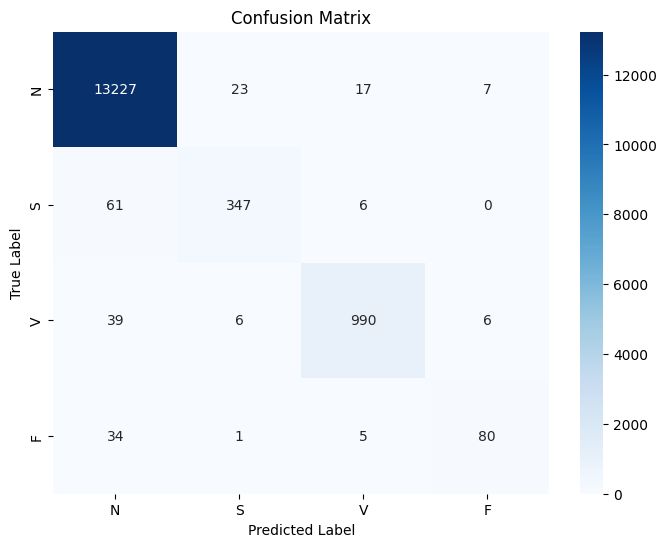

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     13274
           S       0.92      0.84      0.88       414
           V       0.97      0.95      0.96      1041
           F       0.86      0.67      0.75       120

    accuracy                           0.99     14849
   macro avg       0.94      0.86      0.90     14849
weighted avg       0.99      0.99      0.99     14849



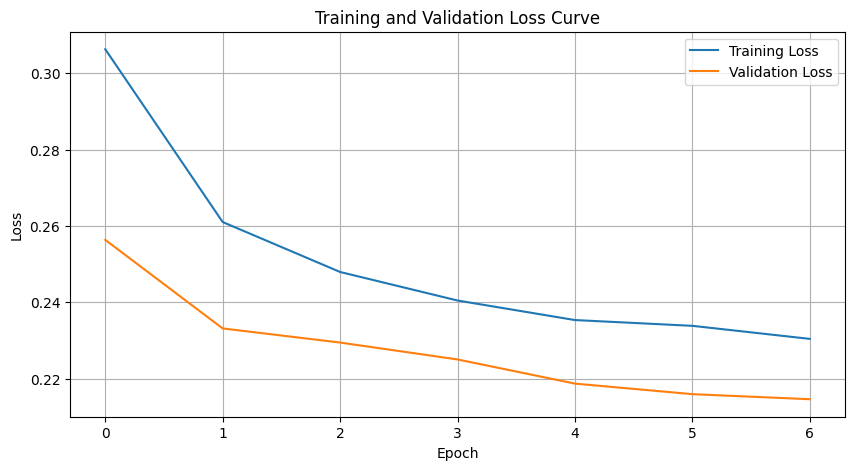

In [8]:
## -- EVAL --- 

model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


test_loss /= len(test_dataloader)
test_accuracy = correct / total

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./results/cm_inter_5_pulse.pdf", format='pdf', bbox_inches='tight') 
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


## PRUNING

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# from sklearn.metrics import f1_score, classification_report, recall_score # Added recall_score
# import copy
# import traceback # For more detailed error messages



# # --- Define custom_blocks ---
# block1_config = {'n_inputs': 1, 'n_outputs': 4, 'kernel_size': 9, 'dilation': 1,  'stride': 2,  'dropout': 0.036, 'not_first': False}
# block2_config = {'n_inputs': 4, 'n_outputs': 8, 'kernel_size': 9, 'dilation': 4,  'stride': 1,  'dropout': 0.036, 'not_first': True}
# block3_config = {'n_inputs': 8, 'n_outputs': 16, 'kernel_size': 9, 'dilation': 16, 'stride': 1,  'dropout': 0, 'not_first': True}

# custom_blocks_list = [
#     TemporalBlock2d(**block1_config),
#     TemporalBlock2d(**block2_config),
#     TemporalBlock2d(**block3_config)
# ]
# NUM_MODEL_OUTPUTS = 4

# # --- Device Setup ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # --- Load Model and Checkpoint ---
# pruning_model = TCN2d(custom_blocks=copy.deepcopy(custom_blocks_list), num_outputs=NUM_MODEL_OUTPUTS).to(device)
# checkpoint_path = './weights/best_model.pth'
# try:
#     checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
#     pruning_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
#     pruning_model.eval()
#     print(f"Successfully loaded pruning_model from {checkpoint_path}")
# except FileNotFoundError:
#     print(f"ERROR: Checkpoint file not found at {checkpoint_path}. Pruning cannot proceed.")
#     raise
# except Exception as e:
#     print(f"ERROR: Could not load model checkpoint: {e}")
#     raise

# original_model = TCN2d(custom_blocks=copy.deepcopy(custom_blocks_list), num_outputs=NUM_MODEL_OUTPUTS).to(device)
# original_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
# original_model.eval()
# print(f"Successfully loaded original_model from {checkpoint_path}")


# # --- Channel Importance Evaluation ---
# def evaluate_channel_importance(model_to_evaluate, dataloader, device, block_idx, layer_name='conv2', ref_model=None,
#                                 importance_metric='weighted_f1_delta', target_class_metric=None, target_class_label=None):
#     model_to_evaluate.eval()
#     if ref_model is None:
#         ref_model = copy.deepcopy(model_to_evaluate)
#     ref_model.eval()

#     all_preds_base, all_targets_base = [], []
#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device), y.to(device)
#             y_pred = ref_model(x)
#             all_preds_base.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
#             all_targets_base.extend(y.cpu().numpy())

#     base_macro_f1 = f1_score(all_targets_base, all_preds_base, average="macro", zero_division=0)
#     print(f"Baseline macro F1 (from reference model): {base_macro_f1:.4f}")
#     unique_labels = np.unique(all_targets_base)
#     if len(unique_labels) == 0: # Handle empty validation set case
#         print("Warning: No labels found in validation data during importance evaluation.")
#         return pd.DataFrame(), base_macro_f1
#     print(f"Unique labels in validation: {unique_labels}")


#     base_classwise_f1 = f1_score(all_targets_base, all_preds_base, average=None, labels=unique_labels, zero_division=0)
#     base_classwise_recall = recall_score(all_targets_base, all_preds_base, average=None, labels=unique_labels, zero_division=0)
    
#     # Ensure class_counts has entries for all unique_labels for weighting
#     min_len_bincount = max(unique_labels) + 1 if len(unique_labels) > 0 else 0
#     class_counts_all = np.bincount(all_targets_base, minlength=min_len_bincount)
    
#     # Create class_weights aligned with unique_labels
#     class_weights = np.zeros(len(unique_labels), dtype=float)
#     for i, label in enumerate(unique_labels):
#         if label < len(class_counts_all) and class_counts_all[label] > 0:
#             class_weights[i] = 1.0 / class_counts_all[label]
#         else: # Class not present or count is zero, assign low weight or handle as needed
#             class_weights[i] = 0 # Or some small epsilon if you want it to have minimal impact


#     if class_weights.sum() > 0:
#         class_weights /= class_weights.sum() # Normalize non-zero weights
#     elif len(class_weights) > 0 : # All counts were zero, assign uniform
#         class_weights = np.ones_like(class_weights) / len(class_weights)


#     target_block_orig = model_to_evaluate.temporal_blocks[block_idx]
#     target_conv_orig = getattr(target_block_orig, layer_name)
#     num_channels = target_conv_orig.out_channels
#     if num_channels == 0:
#         print(f"INFO: Layer {layer_name} in block {block_idx} has 0 output channels. Skipping importance evaluation.")
#         return pd.DataFrame(), base_macro_f1


#     results = []
#     print(f"Evaluating importance of {num_channels} channels in block {block_idx}, layer {layer_name} using '{importance_metric}'...")
#     for ch_idx in range(num_channels):
#         temp_model = copy.deepcopy(model_to_evaluate)
#         temp_model.eval()
#         conv_to_modify = getattr(temp_model.temporal_blocks[block_idx], layer_name)

#         def hook_fn(module, input_val, output_val):
#             modified_output = output_val.clone()
#             modified_output[:, ch_idx, :, :] = 0
#             return modified_output
#         handle = conv_to_modify.register_forward_hook(hook_fn)

#         current_preds, current_targets = [], []
#         with torch.no_grad():
#             for x, y in dataloader:
#                 x, y = x.to(device), y.to(device)
#                 y_pred = temp_model(x)
#                 current_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
#                 current_targets.extend(y.cpu().numpy())
#         handle.remove()

#         current_macro_f1 = f1_score(current_targets, current_preds, average="macro", zero_division=0)
#         current_classwise_f1 = f1_score(current_targets, current_preds, average=None, labels=unique_labels, zero_division=0)
#         current_classwise_recall = recall_score(current_targets, current_preds, average=None, labels=unique_labels, zero_division=0)

#         delta_val = 0.0
#         # Note: 'calculated_delta' = MetricAfterZeroing - MetricBase.
#         # Positive delta = zeroing the channel IMPROVED the metric (channel was bad).
#         # Negative delta = zeroing the channel WORSENED the metric (channel was good).
#         if importance_metric == 'weighted_f1_delta':
#             if len(current_classwise_f1) == len(class_weights) and len(base_classwise_f1) == len(class_weights) and len(class_weights) > 0 :
#                 delta_val = np.sum(current_classwise_f1 * class_weights) - np.sum(base_classwise_f1 * class_weights)
#             else:
#                 delta_val = current_macro_f1 - base_macro_f1
#         elif importance_metric == 'macro_f1_delta':
#             delta_val = current_macro_f1 - base_macro_f1
#         elif importance_metric in ['class_f1_delta', 'class_recall_delta']:
#             if target_class_label is None or target_class_metric is None:
#                 raise ValueError("target_class_label and target_class_metric must be specified for class-specific metrics.")
#             try:
#                 class_idx = list(unique_labels).index(target_class_label)
#                 if importance_metric == 'class_f1_delta':
#                     delta_val = current_classwise_f1[class_idx] - base_classwise_f1[class_idx]
#                 else: # class_recall_delta
#                     delta_val = current_classwise_recall[class_idx] - base_classwise_recall[class_idx]
#             except ValueError:
#                 print(f"Warning: Target class {target_class_label} not found in unique_labels. Defaulting to macro_f1_delta.")
#                 delta_val = current_macro_f1 - base_macro_f1
#         else:
#             raise ValueError(f"Unknown importance_metric: {importance_metric}")

#         result_entry = {
#             "channel": ch_idx,
#             "metric_after_zeroing_macro_f1": current_macro_f1, # For reference
#             "calculated_delta": delta_val,
#         }
#         for j_idx, label_val in enumerate(unique_labels):
#              result_entry[f"class_{label_val}_f1_after_zeroing"] = current_classwise_f1[j_idx]
#              result_entry[f"class_{label_val}_recall_after_zeroing"] = current_classwise_recall[j_idx]
#         results.append(result_entry)

#     # Sort by calculated_delta ASCENDING:
#     # - Most negative delta (zeroing hurt most = most important channel) comes FIRST.
#     # - Most positive delta (zeroing helped most = least important/harmful channel) comes LAST.
#     df = pd.DataFrame(results).sort_values("calculated_delta", ascending=True).reset_index(drop=True)
#     return df, base_macro_f1


# # --- Channel Pruning Utilities (Quantization-Aware) ---
# def prune_conv_output_channels(conv_layer: qnn.QuantConv2d, keep_indices: list):
#     if not isinstance(conv_layer, qnn.QuantConv2d):
#         raise TypeError("Expected qnn.QuantConv2d for prune_conv_output_channels")

#     original_out_channels = conv_layer.out_channels
#     keep_indices = sorted(list(set(int(i) for i in keep_indices)))
#     new_out_channels = len(keep_indices)

#     if new_out_channels == original_out_channels:
#         print(f"DEBUG: No change in out_channels for layer. original={original_out_channels}, new={new_out_channels}")
#         return
#     if new_out_channels == 0 and original_out_channels > 0:
#         print(f"ERROR: Attempting to prune all output channels of {conv_layer}. Pruning skipped.")
#         return

#     print(f"DEBUG: Pruning conv output {conv_layer._get_name()} from {original_out_channels} to {new_out_channels} channels, keeping indices {keep_indices}")

#     conv_layer.out_channels = new_out_channels
#     conv_layer.weight.data = conv_layer.weight.data[keep_indices, :, :, :].clone()
#     if conv_layer.bias is not None:
#         if conv_layer.bias.data.shape[0] == original_out_channels:
#             conv_layer.bias.data = conv_layer.bias.data[keep_indices].clone()
#         else:
#             print(f"WARNING: Bias shape {conv_layer.bias.data.shape} mismatch with original_out_channels {original_out_channels}. Bias not pruned.")

#     updated_brevitas_internals = False
#     try:
#         if hasattr(conv_layer, 'weight_quant') and conv_layer.weight_quant is not None and \
#            hasattr(conv_layer.weight_quant, 'tensor_quant') and conv_layer.weight_quant.tensor_quant is not None:
            
#             tensor_quant_module = conv_layer.weight_quant.tensor_quant # e.g. RescalingIntQuant
            
#             if hasattr(tensor_quant_module, 'scaling_impl'):
#                 scaling_impl_module = tensor_quant_module.scaling_impl # e.g. StatsFromParameterScaling

#                 stats_module_for_view = None
#                 # Path for StatsFromParameterScaling
#                 if hasattr(scaling_impl_module, 'parameter_list_stats') and \
#                    hasattr(scaling_impl_module.parameter_list_stats, 'stats') and \
#                    hasattr(scaling_impl_module.parameter_list_stats.stats, 'stats_output_shape'):
#                     stats_module_for_view = scaling_impl_module.parameter_list_stats.stats
#                 # Path for ParameterFromRuntimeStatsScaling (often for activations)
#                 elif hasattr(scaling_impl_module, 'stats') and \
#                      hasattr(scaling_impl_module.stats, 'stats_output_shape'):
#                     stats_module_for_view = scaling_impl_module.stats
                
#                 if stats_module_for_view:
#                     current_stats_view_shape = list(stats_module_for_view.stats_output_shape)
#                     if len(current_stats_view_shape) > 0 and current_stats_view_shape[0] == original_out_channels:
#                         current_stats_view_shape[0] = new_out_channels
#                         stats_module_for_view.stats_output_shape = tuple(current_stats_view_shape)
#                         print(f"INFO: Updated stats_module_for_view.stats_output_shape to {stats_module_for_view.stats_output_shape}")
#                         updated_brevitas_internals = True
#                     else:
#                         print(f"WARNING: stats_output_shape for view check failed/unexpected. Path: {stats_module_for_view}, Shape: {current_stats_view_shape}, Orig_out: {original_out_channels}, New_out: {new_out_channels}")
#                 else:
#                     print(f"WARNING: Path to .stats_output_shape (for view) not found under scaling_impl: {type(scaling_impl_module)}")

#                 if hasattr(scaling_impl_module, 'learned_stats') and scaling_impl_module.learned_stats is not None:
#                     learned_stats_param = scaling_impl_module.learned_stats
#                     print(f"DEBUG: Found learned_stats. Type: {type(learned_stats_param)}, Is nn.Parameter: {isinstance(learned_stats_param, nn.Parameter)}")
#                     if isinstance(learned_stats_param, nn.Parameter):
#                         print(f"DEBUG: learned_stats.ndim: {learned_stats_param.ndim}, shape: {learned_stats_param.shape}, original_out_channels: {original_out_channels}")
#                         if learned_stats_param.ndim > 0 and learned_stats_param.shape[0] == original_out_channels:
#                             sliced_data = learned_stats_param.data[keep_indices].clone()
#                             scaling_impl_module.learned_stats = nn.Parameter(sliced_data)
#                             print(f"INFO: Sliced and reassigned learned_stats parameter. New shape: {scaling_impl_module.learned_stats.shape}")
#                             updated_brevitas_internals = True
#                         else:
#                             print(f"WARNING: learned_stats param shape mismatch or not per-channel for slicing. Shape: {learned_stats_param.shape}, Expected dim0: {original_out_channels}")
#                     else:
#                         print(f"WARNING: learned_stats found but is not an nn.Parameter. Type: {type(learned_stats_param)}")
#                 else:
#                     print(f"DEBUG: scaling_impl_module ({type(scaling_impl_module)}) does not have 'learned_stats' or it is None. This is expected for dynamic scalers like StatsFromParameterScaling.")
#             else:
#                  print(f"WARNING: {type(tensor_quant_module)} has no 'scaling_impl' attribute.")

#             quant_proxy = conv_layer.weight_quant
#             if hasattr(quant_proxy, 'broadcast_shape_impl') and hasattr(quant_proxy.broadcast_shape_impl, 'shape'):
#                 current_broadcast_shape = list(quant_proxy.broadcast_shape_impl.shape)
#                 if len(current_broadcast_shape) > 0 and current_broadcast_shape[0] == original_out_channels:
#                      current_broadcast_shape[0] = new_out_channels
#                      quant_proxy.broadcast_shape_impl.shape = tuple(current_broadcast_shape)
#                      print(f"INFO: Updated weight_quant.broadcast_shape_impl.shape to {quant_proxy.broadcast_shape_impl.shape}")
#                      updated_brevitas_internals = True
#                 elif not updated_brevitas_internals and len(current_broadcast_shape) > 0 :
#                      print(f"WARNING: broadcast_shape_impl.shape check failed. Current: {current_broadcast_shape}, Orig: {original_out_channels}, New: {new_out_channels}")
#             else:
#                 print(f"DEBUG: conv_layer.weight_quant ({type(quant_proxy)}) or its broadcast_shape_impl not found or no shape attr.")

#     except Exception as e:
#         print(f"ERROR during Brevitas internal update for {conv_layer._get_name()}: {e}")
#         traceback.print_exc()

#     if not updated_brevitas_internals:
#         print(f"CRITICAL WARNING: Potentially failed to update Brevitas internal scaling attributes for layer {conv_layer._get_name()}. Review logs.")


# def prune_conv_input_channels(conv_layer: qnn.QuantConv2d, keep_indices: list):
#     if not isinstance(conv_layer, qnn.QuantConv2d):
#         raise TypeError("Expected qnn.QuantConv2d for prune_conv_input_channels")
#     original_in_channels = conv_layer.in_channels
#     keep_indices = sorted(list(set(int(i) for i in keep_indices)))
#     new_in_channels = len(keep_indices)

#     if new_in_channels == original_in_channels: return
#     if new_in_channels == 0 and original_in_channels > 0:
#         print(f"ERROR: Attempting to prune all input channels of {conv_layer._get_name()}. Skipped.")
#         return

#     print(f"DEBUG: Pruning conv input {conv_layer._get_name()} from {original_in_channels} to {new_in_channels}, keeping input indices {keep_indices}")
#     conv_layer.in_channels = new_in_channels
#     conv_layer.weight.data = conv_layer.weight.data[:, keep_indices, :, :].clone()


# def prune_batchnorm(bn_layer: nn.BatchNorm2d, keep_indices: list):
#     if not isinstance(bn_layer, nn.BatchNorm2d):
#         raise TypeError("Expected nn.BatchNorm2d")
#     original_features = bn_layer.num_features
#     keep_indices = sorted(list(set(int(i) for i in keep_indices)))
#     new_features = len(keep_indices)

#     if new_features == original_features: return
#     if new_features == 0 and original_features > 0:
#         print(f"ERROR: Attempting to prune all features of {bn_layer}. Skipped.")
#         return

#     print(f"DEBUG: Pruning BatchNorm {bn_layer} from {original_features} to {new_features} features.")
#     bn_layer.num_features = new_features
#     if bn_layer.weight is not None: # Check if affine
#         bn_layer.weight.data = bn_layer.weight.data[keep_indices].clone()
#         bn_layer.bias.data = bn_layer.bias.data[keep_indices].clone()
#     bn_layer.running_mean = bn_layer.running_mean[keep_indices].clone()
#     bn_layer.running_var = bn_layer.running_var[keep_indices].clone()


# # --- Main Pruning Pipeline ---
# def run_pruning_pipeline_step(
#     current_model: TCN2d, reference_original_model: TCN2d, val_loader, device_to_use,
#     block_idx_to_prune: int, layer_to_prune_name: str = 'conv2', pruning_config: dict = None
# ):
#     default_pruning_config = {
#         'importance_metric': 'weighted_f1_delta',
#         'pruning_threshold': 0.0,
#         'keep_channel_rule': 'delta <= threshold', # Keep if calculated_delta is less_than_or_equal_to threshold
#                                                    # calculated_delta = (metric_after_zeroing - metric_base)
#                                                    # So positive delta means zeroing IMPROVED metric (channel was bad)
#                                                    # This rule (delta <= 0.0) means keep channels that HURT or have NO impact when zeroed
#         'min_channel_ratio': 0.1
#     }
#     cfg = {**default_pruning_config, **(pruning_config if pruning_config is not None else {})}

#     print(f"\n--- Pruning Block {block_idx_to_prune}, Layer {layer_to_prune_name} using config: {cfg} ---")

#     df_importance, base_metric_val = evaluate_channel_importance(
#         model_to_evaluate=current_model, dataloader=val_loader, device=device_to_use,
#         block_idx=block_idx_to_prune, layer_name=layer_to_prune_name, ref_model=reference_original_model,
#         importance_metric=cfg['importance_metric'],
#         target_class_metric=cfg.get('target_class_metric'), target_class_label=cfg.get('target_class_label')
#     )
    
#     if df_importance.empty:
#         print("Importance DataFrame empty. Skipping pruning.")
#         return current_model, df_importance

#     print("Channel Importance ('calculated_delta' = metric_after_zeroing - metric_base):")
#     print(df_importance.head().to_string())

#     threshold = cfg['pruning_threshold']
#     # Rule: 'delta <= threshold' means: keep channel IF (metric_after_zeroing - metric_base) <= threshold.
#     # For threshold = 0.0: keep channel IF (metric_after_zeroing - metric_base) <= 0.0
#     # This means keep channels that, when zeroed, make performance worse or same.
#     # Prune channels that, when zeroed, make performance better (delta > 0.0).
#     keep_channel_indices = df_importance[df_importance["calculated_delta"] <= threshold]["channel"].tolist()
#     print(f"Initial selection to keep (delta <= {threshold}): {len(keep_channel_indices)} channels.")

#     num_original_channels = getattr(current_model.temporal_blocks[block_idx_to_prune], layer_to_prune_name).out_channels
#     min_channel_ratio = cfg['min_channel_ratio']
#     min_channels_to_keep_abs = max(1, int(num_original_channels * min_channel_ratio))


#     if len(keep_channel_indices) < min_channels_to_keep_abs and num_original_channels > 0 :
#         if not keep_channel_indices : # All channels failed the threshold rule
#              print(f"⚠️ Threshold rule (delta <= {threshold}) would prune all channels.")
#         else: # Some kept, but fewer than min_channel_ratio
#              print(f"⚠️ Current selection of {len(keep_channel_indices)} channels is less than min_ratio requirement ({min_channels_to_keep_abs}).")
        
#         print(f"Applying min_channel_ratio fallback: keeping {min_channels_to_keep_abs} most important channels.")
#         # df_importance sorted by calculated_delta ASC (most important/most negative delta first)
#         keep_channel_indices = df_importance.head(min_channels_to_keep_abs)["channel"].tolist()


#     if len(keep_channel_indices) == num_original_channels:
#         print(f"✅ No channels pruned for this layer. All {num_original_channels} channels kept.")
#         return current_model, df_importance

#     print(f"Final decision: Original: {num_original_channels}. To Keep: {len(keep_channel_indices)} -> {sorted(keep_channel_indices)}.")
#     if not keep_channel_indices and num_original_channels > 0: # Should be caught by fallback
#         print("ERROR: No channels to keep. Aborting pruning step.")
#         return current_model, df_importance
#     if num_original_channels == 0:
#         print(f"✅ Layer already has 0 channels. Skipping.")
#         return current_model, df_importance

#     target_block_pruning = current_model.temporal_blocks[block_idx_to_prune]
#     conv_to_prune = getattr(target_block_pruning, layer_to_prune_name)
#     prune_conv_output_channels(conv_to_prune, keep_channel_indices)

#     if layer_to_prune_name == "conv2":
#         prune_batchnorm(target_block_pruning.bn2, keep_channel_indices)
#         if block_idx_to_prune == len(current_model.temporal_blocks) - 1:
#             if hasattr(current_model, "fc") and isinstance(current_model.fc, qnn.QuantConv2d):
#                 print(f"Pruning input of model.fc layer to {len(keep_channel_indices)} channels.")
#                 prune_conv_input_channels(current_model.fc, keep_channel_indices)
#         else:
#             next_block_pruning = current_model.temporal_blocks[block_idx_to_prune + 1]
#             next_block_original = reference_original_model.temporal_blocks[block_idx_to_prune + 1]
#             orig_next_conv1_params = next_block_original.conv1
#             curr_out_ch_next_conv1 = next_block_pruning.conv1.out_channels
#             curr_next_conv1_weights = next_block_pruning.conv1.weight.data.clone()
#             known_w_bw, known_a_bw = 8, 8

#             reconstructed_next_conv1 = qnn.QuantConv2d(
#                 in_channels=len(keep_channel_indices), out_channels=curr_out_ch_next_conv1,
#                 kernel_size=orig_next_conv1_params.kernel_size, stride=orig_next_conv1_params.stride,
#                 padding=orig_next_conv1_params.padding, dilation=orig_next_conv1_params.dilation,
#                 groups=orig_next_conv1_params.groups, bias=orig_next_conv1_params.bias is not None,
#                 weight_quant=copy.deepcopy(orig_next_conv1_params.weight_quant),
#                 input_quant=copy.deepcopy(orig_next_conv1_params.input_quant),
#                 weight_bit_width=known_w_bw, act_bit_width=known_a_bw,
#             ).to(device_to_use)
            
#             reconstructed_next_conv1.weight.data = curr_next_conv1_weights[:curr_out_ch_next_conv1, :len(keep_channel_indices), :, :].clone()
#             next_block_pruning.conv1 = reconstructed_next_conv1
#             print(f"Reconstructed next_block.conv1: in={len(keep_channel_indices)}, out={curr_out_ch_next_conv1}")

#             orig_bn_eps, orig_bn_momentum = next_block_original.bn1.eps, next_block_original.bn1.momentum
#             reconstructed_next_bn1 = nn.BatchNorm2d(
#                 num_features=reconstructed_next_conv1.out_channels,
#                 eps=orig_bn_eps, momentum=orig_bn_momentum
#             ).to(device_to_use)
            
#             bn_state_to_load = {
#                 'weight': next_block_pruning.bn1.weight.data[:curr_out_ch_next_conv1].clone(),
#                 'bias': next_block_pruning.bn1.bias.data[:curr_out_ch_next_conv1].clone(),
#                 'running_mean': next_block_pruning.bn1.running_mean[:curr_out_ch_next_conv1].clone(),
#                 'running_var': next_block_pruning.bn1.running_var[:curr_out_ch_next_conv1].clone(),
#                 'num_batches_tracked': next_block_pruning.bn1.num_batches_tracked.clone()
#             }
#             reconstructed_next_bn1.load_state_dict(bn_state_to_load)
#             next_block_pruning.bn1 = reconstructed_next_bn1
#             print(f"Reconstructed next_block.bn1: features={reconstructed_next_conv1.out_channels}")

#     elif layer_to_prune_name == "conv1":
#         prune_batchnorm(target_block_pruning.bn1, keep_channel_indices)
#         target_conv2_same_block = target_block_pruning.conv2
#         print(f"Pruning input of current_block.conv2 layer to {len(keep_channel_indices)} channels.")
#         prune_conv_input_channels(target_conv2_same_block, keep_channel_indices)

#     print(f"✅ Pruned block {block_idx_to_prune}, layer {layer_to_prune_name} to {len(keep_channel_indices)} channels.")
#     return current_model, df_importance


# # --- Validation Function ---
# def validate_model(model_to_validate, dataloader, device_to_use, model_name="Model", print_detailed_report=False):
#     model_to_validate.eval()
#     all_preds_val, all_targets_val = [], []
#     if dataloader is None or len(dataloader.dataset) == 0:
#         print(f"Warning: Dataloader for {model_name} is None or empty. Skipping validation.")
#         return 0.0 # Or appropriate default
#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device_to_use), y.to(device_to_use)
#             y_pred = model_to_validate(x)
#             all_preds_val.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
#             all_targets_val.extend(y.cpu().numpy())
    
#     if not all_targets_val: # No data processed
#         print(f"Warning: No data processed for {model_name} validation.")
#         return 0.0

#     macro_f1_val = f1_score(all_targets_val, all_preds_val, average='macro', zero_division=0)
#     weighted_f1_val = f1_score(all_targets_val, all_preds_val, average='weighted', zero_division=0)
#     accuracy_val = (np.array(all_preds_val) == np.array(all_targets_val)).mean()
    
#     print(f"\n🔍 {model_name} - Macro F1: {macro_f1_val:.4f}, Weighted F1: {weighted_f1_val:.4f}, Accuracy: {accuracy_val:.4f}")
#     if print_detailed_report:
#         print("\n📊 Detailed per-class report:\n")
#         report_labels = np.unique(np.concatenate((all_targets_val, all_preds_val)))
#         print(classification_report(all_targets_val, all_preds_val, labels=report_labels, digits=4, zero_division=0))
#     return macro_f1_val


# # --- Main Execution ---
# if __name__ == "__main__":
   


#     print("--- Validating Original Unpruned Model (on val_dataloader) ---")
#     validate_model(original_model, val_dataloader, device, model_name="Original Model (Val)", print_detailed_report=True)

#     # --- Pruning Strategy: Only prune channels that HARM performance (positive delta) ---
#     # Delta = MetricAfterZeroing - MetricBase. Positive delta = zeroing improved = channel was harmful.
#     # We keep channels if delta <= 0 (zeroing hurt or no change).
#     config_prune_harmful_weighted_f1 = {
#         'importance_metric': 'weighted_f1_delta', # More sensitive to minority classes
#         'pruning_threshold': 0.0,                 # Threshold for the delta
#         'keep_channel_rule': 'delta <= threshold',# Channels with delta > 0.0 will be candidates for pruning
#         'min_channel_ratio': 0.75                 # Keep at least 75% of channels, especially for small layers
#     }
    
#     current_pruning_config = config_prune_harmful_weighted_f1
#     print(f"\n======= RUNNING PRUNING WITH CONFIG: {current_pruning_config} =======")

#     layers_to_prune_schedule = [
#         (2, 'conv2'),
#         (1, 'conv2'),
#         (0, 'conv2'),
#     ]
    
#     # --- Isolate first pruning step for Block 0 (most sensitive) for debugging ---
#     print("\n\n======= ISOLATING PRUNING FOR BLOCK 0, conv2 (most sensitive layer) =======")
#     isolated_pruning_config_block0 = {
#         'importance_metric': 'weighted_f1_delta',
#         'pruning_threshold': 0.0,
#         'keep_channel_rule': 'delta <= threshold', # Keep if delta <= 0
#         'min_channel_ratio': 1.0 # FORCE KEEPING ALL CHANNELS IN BLOCK 0 INITIALLY if fallback is hit
#                                  # This means if threshold prunes all, fallback keeps all.
#                                  # If threshold doesn't prune all, it proceeds.
#     }
#     if NUM_MODEL_OUTPUTS == 4 and custom_blocks_list[0].conv2.out_channels == 4 : # Specific for block0.conv2 (4 channels)
#         print(f"Applying protective min_channel_ratio for Block 0 (4 channels): {isolated_pruning_config_block0['min_channel_ratio']}")


#     # Test Block 0 first with protective config
#     pruning_model_test_b0, df_b0 = run_pruning_pipeline_step(
#         current_model=copy.deepcopy(pruning_model), # Use a copy for this isolated test
#         reference_original_model=original_model,
#         val_loader=val_dataloader,
#         device_to_use=device,
#         block_idx_to_prune=0,
#         layer_to_prune_name='conv2',
#         pruning_config=isolated_pruning_config_block0
#     )
#     print(f"--- Full Importance DataFrame for ISOLATED Block 0, conv2 ---")
#     print(df_b0.to_string())
#     validate_model(pruning_model_test_b0, val_dataloader, device, 
#                    model_name=f"ISOLATED - After Pruning (B0, conv2) (Val)", 
#                    print_detailed_report=True)
#     print("=======================================================================\n\n")


#     # --- Now run the full pipeline ---
#     # You might want to reset pruning_model to a fresh copy from checkpoint before this full run,
#     # if the isolated test modified it in a way you don't want carried over.
#     # For now, assuming pruning_model is from checkpoint at the start of this if __name__ block.
    
#     print(f"\n======= STARTING FULL PRUNING PIPELINE with main config: {current_pruning_config} =======")
#     for block_idx_iter, layer_name_iter in layers_to_prune_schedule:
#         # Apply adaptive min_channel_ratio for the full run
#         active_min_channel_ratio = current_pruning_config['min_channel_ratio'] # Default from chosen config
#         if block_idx_iter == 0:
#             active_min_channel_ratio = 0.75 # Example: More protective for block 0
#             print(f"Adaptive min_channel_ratio for Block {block_idx_iter}: {active_min_channel_ratio}")
#         elif block_idx_iter == 1:
#             active_min_channel_ratio = 0.5 # Example: Moderate for block 1
#             print(f"Adaptive min_channel_ratio for Block {block_idx_iter}: {active_min_channel_ratio}")
        
#         step_config = {**current_pruning_config, 'min_channel_ratio': active_min_channel_ratio}

#         pruning_model, df_importance_step = run_pruning_pipeline_step(
#             current_model=pruning_model,
#             reference_original_model=original_model,
#             val_loader=val_dataloader,
#             device_to_use=device,
#             block_idx_to_prune=block_idx_iter,
#             layer_to_prune_name=layer_name_iter,
#             pruning_config=step_config
#         )
#         print(f"--- Full Importance DataFrame for Block {block_idx_iter}, {layer_name_iter} ---")
#         print(df_importance_step.to_string())

#         validate_model(pruning_model, val_dataloader, device, 
#                        model_name=f"After Pruning (B{block_idx_iter}, {layer_name_iter}) (Val)", 
#                        print_detailed_report=True) # Detailed report after each step

#     print("\n--- Final Pruned Model Performance (on val_dataloader) ---")
#     validate_model(pruning_model, val_dataloader, device, model_name="Final Pruned Model (Val)", print_detailed_report=True)

Using device: cpu
Successfully loaded pruning_model from ./weights/best_model.pth
Successfully loaded original_model from ./weights/best_model.pth
--- Validating Original Unpruned Model (on val_dataloader) ---


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 Original Model (Val) - Macro F1: 0.9433, Weighted F1: 0.9919, Accuracy: 0.9919

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9952    0.9971    0.9961     13478
           1     0.9405    0.9004    0.9200       281
           2     0.9722    0.9679    0.9701      1122
           3     0.9217    0.8548    0.8870       124

    accuracy                         0.9919     15005
   macro avg     0.9574    0.9301    0.9433     15005
weighted avg     0.9918    0.9919    0.9919     15005


======= RUNNING PRUNING WITH CONFIG: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'keep_channel_rule': 'delta <= threshold', 'min_channel_ratio': 0.75} =======


======= ISOLATING PRUNING FOR BLOCK 0, conv2 (most sensitive layer) =======
Applying protective min_channel_ratio for Block 0 (4 channels): 1.0

--- Pruning Block 0, Layer conv2 using config: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'kee

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Baseline macro F1 (from reference model): 0.9433
Unique labels in validation: [0 1 2 3]
Evaluating importance of 4 channels in block 0, layer conv2 using 'weighted_f1_delta'...


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally

Channel Importance ('calculated_delta' = metric_after_zeroing - metric_base):
   channel  metric_after_zeroing_macro_f1  calculated_delta  class_0_f1_after_zeroing  class_0_recall_after_zeroing  class_1_f1_after_zeroing  class_1_recall_after_zeroing  class_2_f1_after_zeroing  class_2_recall_after_zeroing  class_3_f1_after_zeroing  class_3_recall_after_zeroing
0        3                       0.770527         -0.275360                  0.984684                      0.996958                  0.610753                      0.505338                  0.883317                      0.816399                  0.603352                      0.435484
1        2                       0.808166         -0.222918                  0.988001                      0.992729                  0.675277                      0.651246                  0.916324                      0.893048                  0.653061                      0.516129
2        0                       0.897750         -0.063222           

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 ISOLATED - After Pruning (B0, conv2) (Val) - Macro F1: 0.9433, Weighted F1: 0.9919, Accuracy: 0.9919

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9952    0.9971    0.9961     13478
           1     0.9405    0.9004    0.9200       281
           2     0.9722    0.9679    0.9701      1122
           3     0.9217    0.8548    0.8870       124

    accuracy                         0.9919     15005
   macro avg     0.9574    0.9301    0.9433     15005
weighted avg     0.9918    0.9919    0.9919     15005




======= STARTING FULL PRUNING PIPELINE with main config: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'keep_channel_rule': 'delta <= threshold', 'min_channel_ratio': 0.75} =======

--- Pruning Block 2, Layer conv2 using config: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'keep_channel_rule': 'delta <= threshold', 'min_channel_ratio': 0.75} ---


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Baseline macro F1 (from reference model): 0.9433
Unique labels in validation: [0 1 2 3]
Evaluating importance of 16 channels in block 2, layer conv2 using 'weighted_f1_delta'...


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally

Channel Importance ('calculated_delta' = metric_after_zeroing - metric_base):
   channel  metric_after_zeroing_macro_f1  calculated_delta  class_0_f1_after_zeroing  class_0_recall_after_zeroing  class_1_f1_after_zeroing  class_1_recall_after_zeroing  class_2_f1_after_zeroing  class_2_recall_after_zeroing  class_3_f1_after_zeroing  class_3_recall_after_zeroing
0        2                       0.916671         -0.066990                  0.995298                      0.997329                  0.920000                      0.900356                  0.968778                      0.967914                  0.782609                      0.653226
1       11                       0.923742         -0.029246                  0.995006                      0.997774                  0.897527                      0.903915                  0.948777                      0.916221                  0.853659                      0.846774
2       10                       0.933035         -0.023732           

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 After Pruning (B2, conv2) (Val) - Macro F1: 0.8993, Weighted F1: 0.9880, Accuracy: 0.9874

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9966    0.9908    0.9937     13478
           1     0.8878    0.9288    0.9078       281
           2     0.9663    0.9706    0.9684      1122
           3     0.6087    0.9032    0.7273       124

    accuracy                         0.9874     15005
   macro avg     0.8648    0.9484    0.8993     15005
weighted avg     0.9891    0.9874    0.9880     15005

Adaptive min_channel_ratio for Block 1: 0.5

--- Pruning Block 1, Layer conv2 using config: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'keep_channel_rule': 'delta <= threshold', 'min_channel_ratio': 0.5} ---


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Baseline macro F1 (from reference model): 0.9433
Unique labels in validation: [0 1 2 3]
Evaluating importance of 8 channels in block 1, layer conv2 using 'weighted_f1_delta'...


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally

Channel Importance ('calculated_delta' = metric_after_zeroing - metric_base):
   channel  metric_after_zeroing_macro_f1  calculated_delta  class_0_f1_after_zeroing  class_0_recall_after_zeroing  class_1_f1_after_zeroing  class_1_recall_after_zeroing  class_2_f1_after_zeroing  class_2_recall_after_zeroing  class_3_f1_after_zeroing  class_3_recall_after_zeroing
0        2                       0.852309         -0.203944                  0.990153                      0.984790                  0.866906                      0.857651                  0.958772                      0.974153                  0.593407                      0.870968
1        1                       0.851036         -0.192370                  0.990230                      0.985087                  0.821485                      0.925267                  0.961178                      0.959893                  0.631250                      0.814516
2        4                       0.856634         -0.185807           

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 After Pruning (B1, conv2) (Val) - Macro F1: 0.8993, Weighted F1: 0.9880, Accuracy: 0.9874

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9966    0.9908    0.9937     13478
           1     0.8878    0.9288    0.9078       281
           2     0.9663    0.9706    0.9684      1122
           3     0.6087    0.9032    0.7273       124

    accuracy                         0.9874     15005
   macro avg     0.8648    0.9484    0.8993     15005
weighted avg     0.9891    0.9874    0.9880     15005

Adaptive min_channel_ratio for Block 0: 0.75

--- Pruning Block 0, Layer conv2 using config: {'importance_metric': 'weighted_f1_delta', 'pruning_threshold': 0.0, 'keep_channel_rule': 'delta <= threshold', 'min_channel_ratio': 0.75} ---


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Baseline macro F1 (from reference model): 0.9433
Unique labels in validation: [0 1 2 3]
Evaluating importance of 4 channels in block 0, layer conv2 using 'weighted_f1_delta'...


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally

Channel Importance ('calculated_delta' = metric_after_zeroing - metric_base):
   channel  metric_after_zeroing_macro_f1  calculated_delta  class_0_f1_after_zeroing  class_0_recall_after_zeroing  class_1_f1_after_zeroing  class_1_recall_after_zeroing  class_2_f1_after_zeroing  class_2_recall_after_zeroing  class_3_f1_after_zeroing  class_3_recall_after_zeroing
0        3                       0.749118         -0.323452                  0.982469                      0.989613                  0.591270                      0.530249                  0.886148                      0.832442                  0.536585                      0.532258
1        1                       0.799533         -0.323348                  0.985167                      0.975738                  0.841487                      0.765125                  0.952505                      0.974153                  0.418972                      0.854839
2        0                       0.823424         -0.260566           

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 After Pruning (B0, conv2) (Val) - Macro F1: 0.8993, Weighted F1: 0.9880, Accuracy: 0.9874

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9966    0.9908    0.9937     13478
           1     0.8878    0.9288    0.9078       281
           2     0.9663    0.9706    0.9684      1122
           3     0.6087    0.9032    0.7273       124

    accuracy                         0.9874     15005
   macro avg     0.8648    0.9484    0.8993     15005
weighted avg     0.9891    0.9874    0.9880     15005


--- Final Pruned Model Performance (on val_dataloader) ---


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



🔍 Final Pruned Model (Val) - Macro F1: 0.8993, Weighted F1: 0.9880, Accuracy: 0.9874

📊 Detailed per-class report:

              precision    recall  f1-score   support

           0     0.9966    0.9908    0.9937     13478
           1     0.8878    0.9288    0.9078       281
           2     0.9663    0.9706    0.9684      1122
           3     0.6087    0.9032    0.7273       124

    accuracy                         0.9874     15005
   macro avg     0.8648    0.9484    0.8993     15005
weighted avg     0.9891    0.9874    0.9880     15005



/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


📊 Macro F1-Score: 0.5845
📊 Weighted F1-Score: 0.9139
✅ Test Accuracy: 0.8960


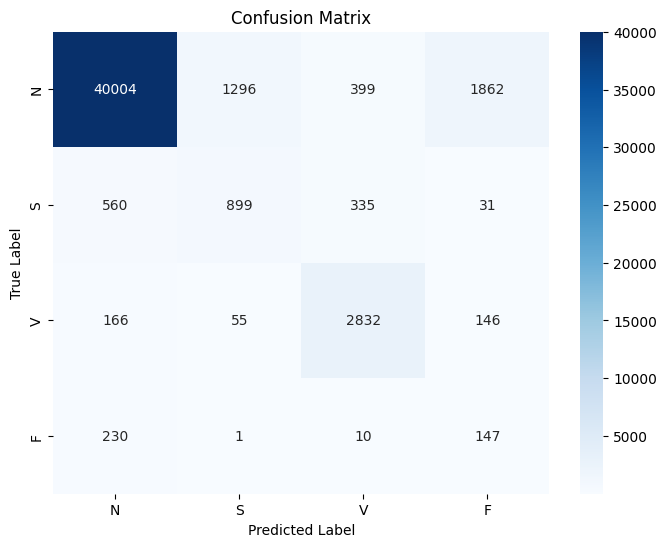

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.92      0.95     43561
           S       0.40      0.49      0.44      1825
           V       0.79      0.89      0.84      3199
           F       0.07      0.38      0.11       388

    accuracy                           0.90     48973
   macro avg       0.56      0.67      0.58     48973
weighted avg       0.94      0.90      0.91     48973



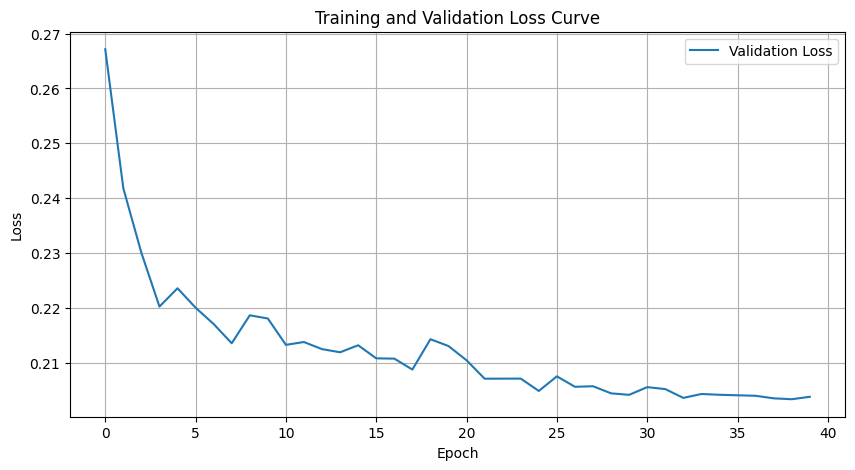

In [ ]:
# ## -- EVAL --- 

# pruning_model.eval()  # Set model to evaluation mode

# all_preds = []
# all_targets = []
# test_loss = 0.0
# correct = 0
# total = 0

# with torch.no_grad():
#     # Here, we assume test_dataloader returns (inputs, targets, window_ids)
#     for inputs, targets in test_dataloader:
#         inputs = inputs.to(device)
#         targets = targets.to(device)
#         outputs = pruning_model(inputs)
#         #loss = criterion(outputs, targets)
#         #test_loss += loss.item()

#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == targets).sum().item()
#         total += targets.size(0)

#         all_preds.extend(predicted.cpu().numpy())
#         all_targets.extend(targets.cpu().numpy())


# #test_loss /= len(test_dataloader)
# test_accuracy = correct / total

# macro_f1 = f1_score(all_targets, all_preds, average="macro")
# weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

# print(f"📊 Macro F1-Score: {macro_f1:.4f}")
# print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

# #print(f"\n📈 Test Loss: {test_loss:.4f}")
# print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# # Plotting Confusion Matrix
# cm = confusion_matrix(all_targets, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=AAMI_CLASS_NAMES,
#             yticklabels=AAMI_CLASS_NAMES)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.savefig("./results/cm_inter_5_pulse.pdf", format='pdf', bbox_inches='tight') 
# plt.show()

# print("📋 Classification Report:")
# print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# # Plotting Training and Validation Loss Curve
# plt.figure(figsize=(10, 5))
# #plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
# plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss Curve")
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# ## finetuning 

# import torch.optim as optim

# def fine_tune_model(model, train_dataloader, device, epochs=5, learning_rate=1e-4):
#     """
#     Fine-tunes the model for a few epochs.
#     """
#     print(f"\n--- Fine-tuning model for {epochs} epochs with LR={learning_rate} ---")
#     model.train() # Set model to training mode

#     # It's generally good to re-initialize the optimizer for the fine-tuning phase,
#     # especially if its state is tied to the original model's parameters.
#     # Filter out parameters that do not require gradients if any, though typically all model params are trainable.
#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
#     # Assuming CrossEntropyLoss for classification

#     for epoch in range(epochs):
#         running_loss = 0.0
#         correct_predictions = 0
#         total_predictions = 0

#         for i, (inputs, labels) in enumerate(train_dataloader):
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total_predictions += labels.size(0)
#             correct_predictions += (predicted == labels).sum().item()

#         epoch_loss = running_loss / len(train_dataloader)
#         epoch_acc = correct_predictions / total_predictions
#         print(f"Fine-tune Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

#     model.eval() # Set model back to evaluation mode
#     print("--- Fine-tuning complete ---")
#     return model

# pruning_model = fine_tune_model(pruning_model, train_dataloader, device, epochs=10, learning_rate=0.002)


--- Fine-tuning model for 10 epochs with LR=0.002 ---
Fine-tune Epoch 1/10, Loss: 0.2046, Accuracy: 0.9909
Fine-tune Epoch 2/10, Loss: 0.2033, Accuracy: 0.9918
Fine-tune Epoch 3/10, Loss: 0.2037, Accuracy: 0.9921
Fine-tune Epoch 4/10, Loss: 0.2018, Accuracy: 0.9923
Fine-tune Epoch 5/10, Loss: 0.2033, Accuracy: 0.9919
Fine-tune Epoch 6/10, Loss: 0.2020, Accuracy: 0.9928
Fine-tune Epoch 7/10, Loss: 0.2031, Accuracy: 0.9913
Fine-tune Epoch 8/10, Loss: 0.2030, Accuracy: 0.9920
Fine-tune Epoch 9/10, Loss: 0.2019, Accuracy: 0.9923
Fine-tune Epoch 10/10, Loss: 0.2030, Accuracy: 0.9919
--- Fine-tuning complete ---


📊 Macro F1-Score: 0.6085
📊 Weighted F1-Score: 0.9360
✅ Test Accuracy: 0.9386


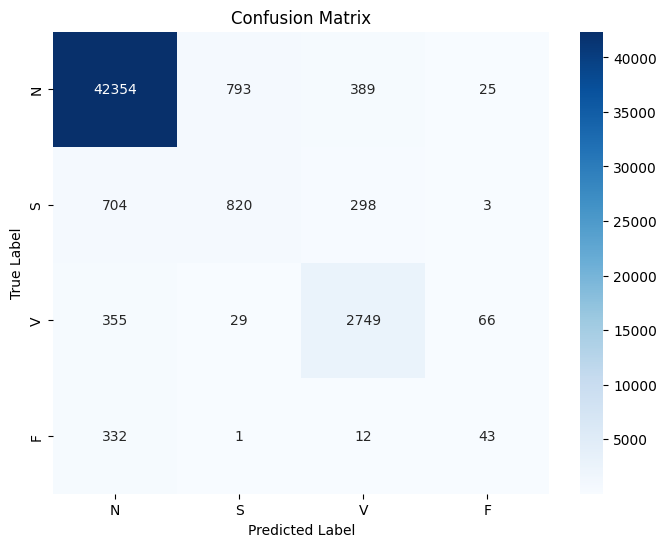

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.97      0.97      0.97     43561
           S       0.50      0.45      0.47      1825
           V       0.80      0.86      0.83      3199
           F       0.31      0.11      0.16       388

    accuracy                           0.94     48973
   macro avg       0.64      0.60      0.61     48973
weighted avg       0.93      0.94      0.94     48973



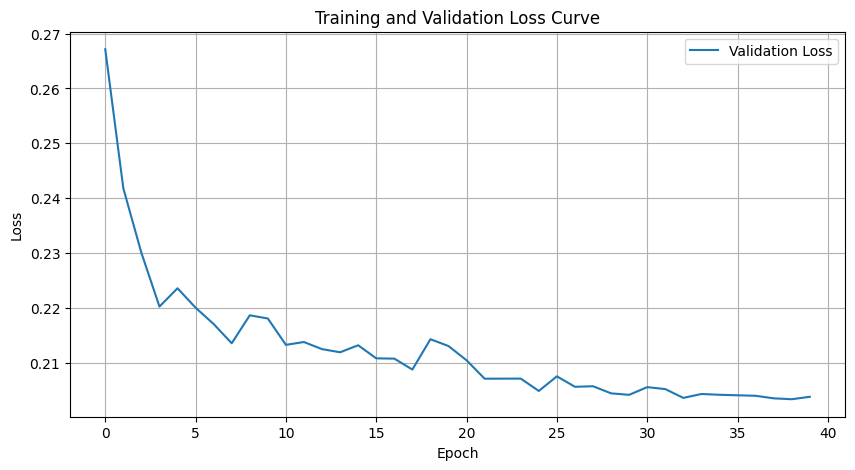

In [ ]:
# ## -- EVAL --- 

# pruning_model.eval()  # Set model to evaluation mode

# all_preds = []
# all_targets = []
# test_loss = 0.0
# correct = 0
# total = 0

# with torch.no_grad():
#     # Here, we assume test_dataloader returns (inputs, targets, window_ids)
#     for inputs, targets in test_dataloader:
#         inputs = inputs.to(device)
#         targets = targets.to(device)
#         outputs = pruning_model(inputs)
#         #loss = criterion(outputs, targets)
#         #test_loss += loss.item()

#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == targets).sum().item()
#         total += targets.size(0)

#         all_preds.extend(predicted.cpu().numpy())
#         all_targets.extend(targets.cpu().numpy())


# #test_loss /= len(test_dataloader)
# test_accuracy = correct / total

# macro_f1 = f1_score(all_targets, all_preds, average="macro")
# weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

# print(f"📊 Macro F1-Score: {macro_f1:.4f}")
# print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

# #print(f"\n📈 Test Loss: {test_loss:.4f}")
# print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# # Plotting Confusion Matrix
# cm = confusion_matrix(all_targets, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=AAMI_CLASS_NAMES,
#             yticklabels=AAMI_CLASS_NAMES)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.savefig("./results/cm_inter_5_pulse.pdf", format='pdf', bbox_inches='tight') 
# plt.show()

# print("📋 Classification Report:")
# print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# # Plotting Training and Validation Loss Curve
# plt.figure(figsize=(10, 5))
# #plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
# plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# print("--- Parameters ---")
# total_params_elements = 0
# for name, param in model.named_parameters():
#     print(f"{name}: {param.shape}, numel: {param.numel()}, dtype: {param.dtype}")
#     total_params_elements += param.numel()
# print(f"Total elements in parameters: {total_params_elements}")

# print("\n--- Buffers ---")
# total_buffer_elements = 0
# for name, buffer_val in model.named_buffers():
#     print(f"{name}: {buffer_val.shape}, numel: {buffer_val.numel()}, dtype: {buffer_val.dtype}")
#     total_buffer_elements += buffer_val.numel()
# print(f"Total elements in buffers: {total_buffer_elements}")

--- Parameters ---
temporal_blocks.0.conv1.weight: torch.Size([4, 1, 9, 1]), numel: 36, dtype: torch.float32
temporal_blocks.0.conv1.input_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.0.bn1.weight: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.bn1.bias: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.conv2.weight: torch.Size([4, 4, 9, 1]), numel: 144, dtype: torch.float32
temporal_blocks.0.conv2.input_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.0.bn2.weight: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.bn2.bias: torch.Size([4]), numel: 4, dtype: torch.float32
temporal_blocks.0.relu.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value: torch.Size([]), numel: 1, dtype: torch.float32
temporal_blocks.1.conv1.weight: torch.Size([8, 4, 9, 1]), nu

## **SAVE WEIGHTS**

In [9]:
#--- Save model ---

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, './weights/tcn_model_final_intra_v2.pth')

print("Training Done, model weights are saved")


Training Done, model weights are saved


## **Export onnx** 

In [ ]:
# --- Export Model ---
model.eval()
model = model.to(device)
dummy_input = torch.randn(1, 1, 665, 1).to(device)
export_qonnx(
    model,
    dummy_input,
    export_path="/home/eveneiha/finn/workspace/finn/onnx/tcn_v41.onnx",
    input_names=["global_in"],
    output_names=["global_out"],
    opset_version=11
)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "global_in"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_2_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    output: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant_output_0"
    name: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/co

# **TCN_INFERENCE MODULE**

In [10]:

# --- Redefinition of TCN to CNN for inference ---   
    
class SliceSelectorStep(nn.Module):
    def __init__(self, step = 1):
        super().__init__()
        self.step = step
               
    def forward(self, x):
        #print(f"Step size: {self.step}")
        return x[:, :, :65:self.step, :]  

class TemporalBlock2d_inf(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dropout=0.2, use_stride = False, last_block = False, not_first=False):
        super(TemporalBlock2d_inf, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.last_block = last_block
        self.conv_quant = Int8ActPerTensorFloat
        
        if not_first:
            self.conv_quant = None
        
        if last_block:
            self.slice_selector_step = SliceSelectorStep(4)
            
        else: 
            self.slice_selector_step = None
        
        
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=self.conv_quant,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)
         
        if use_stride: 
            stride = 4
        else:
            stride = 1
             
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = qnn.QuantReLU(return_quant_tensor=False, act_quant=Uint8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.slice_selector_step(x) if self.slice_selector_step is not None else x
        x = self.bn2(x) 
        x = self.relu(x)
        x = self.dropout2(x)
        return x


class TCN2d_inf(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d_inf, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=None,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
                

    def forward(self, x):
        for block in self.temporal_blocks:
            x = block(x)
            
        x = self.fc(x)
        #x = self.out_quant(x)
        x = x.value if hasattr(x, 'value') else x
        x = x.reshape(x.size(0), -1)
        return x
    
    

block1 = TemporalBlock2d_inf(1, 4,  kernel_size=9,    stride=2,  dropout=0.3, use_stride = True, not_first=False) # if this is true then next dilation must be D2= D2_old/D1
block2 = TemporalBlock2d_inf(4, 8,  kernel_size=9,    stride=1,  dropout=0.3, use_stride = True, not_first=True) # if this is true then next dilation must be D3= D3_old/D2
block3 = TemporalBlock2d_inf(8, 16, kernel_size=9,    stride=1,  dropout=0, not_first=True) # if this is true then next dilation must be D3= D3_old/D2


custom_blocks_inf = [block1, block2, block3]

In [11]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print([type(block) for block in custom_blocks_inf])
model_inf = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=4).to(device)


# --- Load Trained Model Weights ---
# CPU:
checkpoint = torch.load('/home/eveneiha/finn/workspace/ml/model/weights/tcn_model_final_intra_v2.pth', map_location=torch.device('cpu'))
model_inf.load_state_dict(checkpoint['model_state_dict'], strict=False)


model_inf.eval()

tcn = TCN2d_inf(custom_blocks_inf, num_outputs=4)  # or whatever class count


total_params = sum(p.numel() for p in tcn.parameters())
total_buffers = sum(b.numel() for b in tcn.buffers())

size_bytes = (total_params + total_buffers) * 1        # training: float32
size_kb    = size_bytes / 1024
size_mb    = size_kb / 1024

print(f'Parameters   : {total_params:,}')
print(f'Buffers      : {total_buffers:,}')
print(f'Total tensors: {total_params + total_buffers:,}')
print(f'Size  (bytes): {size_bytes}')
print(f'Size    (kB): {size_kb:.3f}')
print(f'Size    (MB): {size_mb:.6f}')

summary(model_inf, input_size=(1, 1, 665, 1))#833  # (batch_size, channels, sequence_length)

[<class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>]
Parameters   : 4,683
Buffers      : 187
Total tensors: 4,870
Size  (bytes): 4870
Size    (kB): 4.756
Size    (MB): 0.004644


/tmp/ipykernel_1723180/1005725778.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/eveneiha/finn/workspace/ml/model/weights/tcn_model_final

Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d_inf                                                                   [1, 4]                    --
├─ModuleList: 1-1                                                           --                        --
│    └─TemporalBlock2d_inf: 2-1                                             [1, 4, 81, 1]             162
│    │    └─QuantConv2d: 3-1                                                [1, 4, 329, 1]            37
│    └─TemporalBlock2d_inf: 2-11                                            --                        (recursive)
│    │    └─QuantReLU: 3-29                                                 --                        (recursive)
│    └─TemporalBlock2d_inf: 2-7                                             --                        (recursive)
│    │    └─QuantConv2d: 3-3                                                --                        (recursive)
│    │    └─B

## **Train sliced model**


In [9]:

# --- Training ---
num_epochs = 40
training_losses = []
validation_losses = []
torch.set_printoptions(precision=4, sci_mode=False)
best_macro_f1 = -float('inf')  # Track best F1 instead of loss
best_epoch = -1

model_inf.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0
   
    # Training loop over batches
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        
        targets = targets.to(device)

        optimizer.zero_grad()   
        
        outputs = model_inf(inputs) # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model_inf.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model_inf(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Accuracy
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {macro_f1:.4f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_epoch = epoch + 1
        torch.save({
            'model_state_dict': model_inf.state_dict(),
        }, './weights/best_model.pth')
        print(f"✅ Best model saved at epoch {best_epoch} with Macro F1: {macro_f1:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)  # Step the scheduler based on validation loss
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    model_inf.train()
    
    

Epoch 1/40 - Train Loss: 1.6627, Val Loss: 1.5965, Val Acc: 0.0295, Val Macro F1: 0.0500
✅ Best model saved at epoch 1 with Macro F1: 0.0500, Val Acc: 0.0295
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 2/40 - Train Loss: 1.6620, Val Loss: 1.6172, Val Acc: 0.0296, Val Macro F1: 0.0363
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 3/40 - Train Loss: 1.6612, Val Loss: 1.6027, Val Acc: 0.0290, Val Macro F1: 0.0466
Current LR: 0.009000


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 4/40 - Train Loss: 1.6605, Val Loss: 1.5996, Val Acc: 0.0294, Val Macro F1: 0.0447
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 5/40 - Train Loss: 1.6599, Val Loss: 1.5684, Val Acc: 0.0292, Val Macro F1: 0.0462
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 6/40 - Train Loss: 1.6597, Val Loss: 1.6056, Val Acc: 0.0296, Val Macro F1: 0.0463
Current LR: 0.004500


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

## **EVAL**

✅ Test Accuracy: 0.9862
📊 Macro F1-Score: 0.8958
📊 Weighted F1-Score: 0.9858


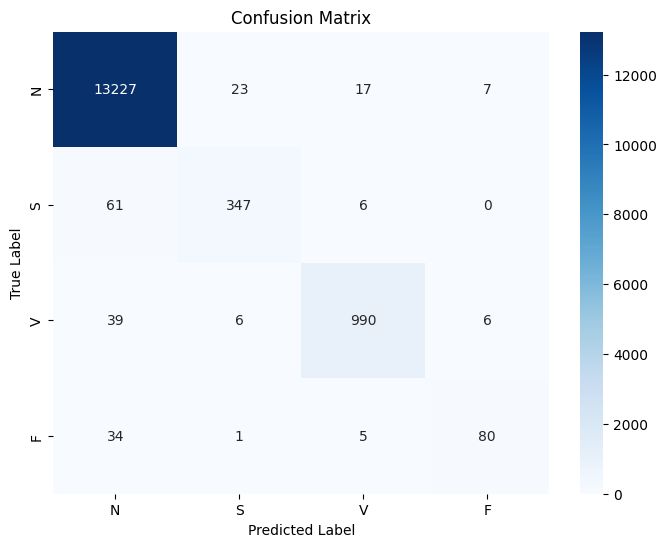

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     13274
           S       0.92      0.84      0.88       414
           V       0.97      0.95      0.96      1041
           F       0.86      0.67      0.75       120

    accuracy                           0.99     14849
   macro avg       0.94      0.86      0.90     14849
weighted avg       0.99      0.99      0.99     14849



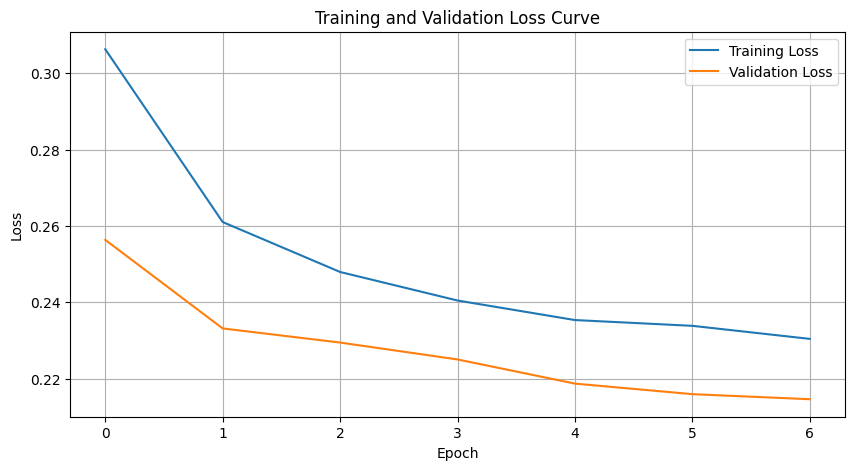

In [12]:
model_inf.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        targets = targets.to(device)
        outputs = model_inf(inputs)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


test_accuracy = correct / total

print(f"✅ Test Accuracy: {test_accuracy:.4f}")

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")
# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./results/cm_inter_5_pulse_inf.pdf", format='pdf', bbox_inches='tight') 

plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
model_inf.eval()
model_inf = model_inf.to(device)
dummy_input = torch.randn(1, 1, 665, 1).to(device)
export_qonnx(
    model_inf,
    dummy_input,
    export_path="/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_inf.onnx",
    input_names=["global_in"],
    output_names=["global_out"],
    opset_version=11
)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "global_in"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_2_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    output: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant_output_0"
    name: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/co

# **MODEL TIME COMPARISON**

In [9]:

import torch
import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table

def benchmark_model(model, input_tensor, name="Model", runs=100, warmup=10, verbose=True):
    model.eval()
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_tensor)

    # Measure inference time
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time_ms = 1000 * sum(times) / len(times)
    std_time_ms = 1000 * (sum((t - sum(times)/len(times))**2 for t in times) / len(times))**0.5

    # FLOPs
    try:
        flops = FlopCountAnalysis(model, input_tensor)
        total_flops = flops.total()
        flops_breakdown = flops.by_module()
    except Exception as e:
        total_flops = None
        flops_breakdown = None
        if verbose:
            print(f"FLOP analysis failed for {name}: {e}")

    # Parameters
    param_table = parameter_count_table(model)

    if verbose:
        print(f"\n📊 Benchmark for {name}")
        print(f"  ⏱️ Avg Inference Time: {avg_time_ms:.2f} ms ± {std_time_ms:.2f} ms over {runs} runs")
        print(f"  🧮 Parameters:\n{param_table}")
        if total_flops is not None:
            print(f"  🔢 Total FLOPs: {total_flops:,}")
            print(f"  🔍 FLOPs by module (top 5):")
            for module, flop in list(flops_breakdown.items())[:5]:
                print(f"    {module}: {flop:,} FLOPs")

    return {
        "name": name,
        "avg_time_ms": avg_time_ms,
        "std_time_ms": std_time_ms,
        "total_flops": total_flops,
        "param_table": param_table,
        "flops_breakdown": flops_breakdown,
    }


# Dummy example, replace with your actual models and input
model1 = TCN2d(custom_blocks=custom_blocks, num_outputs=4).to(device)  # or .to(device)
model2 = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=4).to(device)
input_tensor = torch.randn(1, 1, 665, 1).to(device)  # Example input
input_tensor2 = torch.randn(1, 1, 665, 1).to(device) 

results_normal = benchmark_model(model1, input_tensor, "Model 1")
results_pruned = benchmark_model(model2, input_tensor2, "Model 2")

def print_benchmark_results(*results):
    print("\n===================== 📊 Benchmark Comparison =====================")
    for res in results:
        print(f"\n🔧 {res['name']}")
        print(f"  ⏱️ Avg Inference Time: {res['avg_time_ms']:.2f} ms ± {res['std_time_ms']:.2f} ms")
        if res['total_flops'] is not None:
            print(f"  🔢 Total FLOPs: {res['total_flops']:,}")
        else:
            print("  🔢 Total FLOPs: Not available")
        print(f"  🧮 Parameters:")
        print(res['param_table'])
        if res['flops_breakdown']:
            print(f"  🔍 Top FLOP Modules:")
            for module, flop in list(res['flops_breakdown'].items()):
                          
                if flop != 0: 
                    print(f"    {module}: {flop:,} FLOPs")
        print("-" * 70)

print_benchmark_results(results_normal, results_pruned)

print(f"\n\n ## --- FLOPS COMPARISON --- \n\n Original TCN: {results_normal['total_flops']:,} FLOPs \n\n Optimized TCN: {results_pruned['total_flops']:,} FLOPs \n\n")

NameError: name 'TCN2d' is not defined

## **COMPARING KERNEL COMPUTATIONS**

In [16]:
def count_kernel_computations(model, input_tensor):
    """
    Counts the number of kernel applications for QuantConv2d layers
    based on the output shape during a forward pass.

    Args:
        model (nn.Module): The model to analyze.
        input_tensor (torch.Tensor): A sample input tensor.

    Returns:
        list: A list of tuples, where each tuple contains:
              (layer_name, output_shape, kernel_applications)
        dict: A dictionary mapping layer names to the number of applications.
    """
    if input_tensor is None:
        raise ValueError("input_tensor is required for dynamic computation counting.")

    computation_info = []
    layer_outputs = {}
    hooks = []

    def register_hook(name):
        def hook_fn(module, input, output):
            # Store output shape. Output might be QuantTensor, get value shape.
            if hasattr(output, 'value') and isinstance(output.value, torch.Tensor):
                 layer_outputs[name] = output.value.shape
            elif isinstance(output, torch.Tensor):
                 layer_outputs[name] = output.shape
            else:
                 # Handle cases where output might be tuple etc. (less likely for Conv)
                 layer_outputs[name] = "Unknown/Non-Tensor Output"


        return hook_fn

    # Register hooks
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            hooks.append(module.register_forward_hook(register_hook(name)))

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        try:
            _ = model(input_tensor.to(next(model.parameters()).device))
        except Exception as e:
            print(f"Error during forward pass for computation counting: {e}")
            # Remove hooks even if forward pass failed
            for h in hooks:
                h.remove()
            return [], {} # Return empty results

    # Remove hooks
    for h in hooks:
        h.remove()

    # Calculate kernel applications
    layer_applications = {}
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            if name in layer_outputs and isinstance(layer_outputs[name], torch.Size):
                output_shape = layer_outputs[name]
                # Assumes output shape is (N, C_out, T_out, H_out) or (N, C_out, T_out)
                # Calculate applications = C_out * T_out * H_out (* W_out if applicable)
                # For your TCN2d, it's likely (N, C_out, T_out, 1) -> C_out * T_out * 1
                num_dims = len(output_shape)
                if num_dims >= 3: # Need at least N, C, T
                    C_out = output_shape[1]
                    # Multiply spatial/temporal dimensions starting from index 2
                    spatial_temporal_dims = 1
                    for dim_size in output_shape[2:]:
                        spatial_temporal_dims *= dim_size
                    kernel_apps = C_out * spatial_temporal_dims
                    computation_info.append((name, output_shape, kernel_apps))
                    layer_applications[name] = kernel_apps
                else:
                     computation_info.append((name, output_shape, "N/A (Shape < 3D)"))
                     layer_applications[name] = 0 # Or None

            else:
                 # Layer might not have been called or had non-tensor output
                computation_info.append((name, layer_outputs.get(name, "Not Executed"), 0))
                layer_applications[name] = 0

    return computation_info, layer_applications

def print_computation_summary(model, model_name, input_tensor):
    """Prints the summary of kernel computations."""
    print(f"\n⚙️ Kernel Computation Summary for {model_name}")
    info_list, _ = count_kernel_computations(model, input_tensor)
    total_applications = 0
    if not info_list:
        print("  No QuantConv2d layers found or computation failed.")
        return

    print(f"  {'Layer Name':<30} {'Output Shape':<20} {'Kernel Applications':>20}")
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    for name, shape, apps in info_list:
        shape_str = str(tuple(shape)) if isinstance(shape, torch.Size) else str(shape)
        apps_str = f"{apps:,}" if isinstance(apps, (int, float)) and apps != "N/A (Shape < 3D)" else str(apps)
        print(f"  {name:<30} {shape_str:<20} {apps_str:>20}")
        if isinstance(apps, (int, float)):
            total_applications += apps
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    print(f"  {'Total':<30} {' ':<20} {total_applications:>20,}")
    print("-" * 75)


# --- Run the comparison ---
# Use an appropriate input tensor shape for your models
# Input: (Batch, Channels, Time, Height=1) - e.g., (1, 1, 1000, 1) based on your benchmark
# Adjust the time dimension (1000) if needed for your models
input_data1 = torch.randn(1, 1, 665, 1).to(device) # Matching your forward pass slice
input_data2 = torch.randn(1, 1, 665, 1).to(device) # Matching your forward pass slice

# input_data = torch.randn(1, 1, rf, 1).to(device) # Or use receptive field size if needed

print_computation_summary(model1, "Model (Standard TCN)", input_data1.clone()) # Use clone if input is modified inplace anywhere
print_computation_summary(model2, "Model Inf (With SliceSelector)", input_data2.clone())


⚙️ Kernel Computation Summary for Model (Standard TCN)
  Layer Name                     Output Shape          Kernel Applications
  ------------------------------ -------------------- --------------------
  temporal_blocks.0.conv1        (1, 4, 329, 1)                      1,316
  temporal_blocks.0.conv2        (1, 4, 321, 1)                      1,284
  temporal_blocks.1.conv1        (1, 8, 289, 1)                      2,312
  temporal_blocks.1.conv2        (1, 8, 257, 1)                      2,056
  temporal_blocks.2.conv1        (1, 16, 129, 1)                     2,064
  temporal_blocks.2.conv2        (1, 16, 1, 1)                          16
  fc                             (1, 4, 1, 1)                            4
  ------------------------------ -------------------- --------------------
  Total                                                              9,052
---------------------------------------------------------------------------

⚙️ Kernel Computation Summary for Model In

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
